# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [1]:
!pip install datasets
!pip3 install apache-beam

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.

The conflict is caused by:
    datasets 2.12.0 depends on dill<0.3.7 and >=0.3.0
    multiprocess 0.70.14 depends on dill>=0.3.6

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict



ERROR: Cannot install datasets==2.12.0 and multiprocess==0.70.14 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [2]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [3]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import pickle
import random
import logging
import time

In [4]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

C:\Users\danis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the module from C:\Users\danis\.cache\huggingface\modules\datasets_modules\datasets\wikipedia\aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559 (last modified on Thu Jun  8 18:07:07 2023) since it couldn't be found locally at wikipedia., or remotely on the Hugging Face Hub.
Found cached dataset wikipedia (C:/Users/danis/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)
100%|██████████| 1/1 [00:00<00:00, 37.96it/s]


In [5]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]

# Tokenization	
tokenizer.fit_on_texts(corpus)

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [6]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

Let us look at some examples:

In [7]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 58, 16, 193, 4581, 166, 38, 85, 614, 9, 830, 13, 20, 3798, 99, 1798, 3]
shuffled sentecen:  [2, 99, 830, 1798, 9, 13, 614, 85, 193, 166, 16, 58, 3798, 38, 4581, 20, 3]


Let us look at detokenized data:

In [8]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> 8 protestant 35 <end>
shuffled sentence:  <start> protestant 35 8 <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(shuffled_data, original_data, target_data, test_size = 0.3, random_state = 42)


Depending from the model you plan to build, you might require padding the input sequence

In [10]:
max_sequence_len = max([len(x) for x in original_data])

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

In [11]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 96110


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

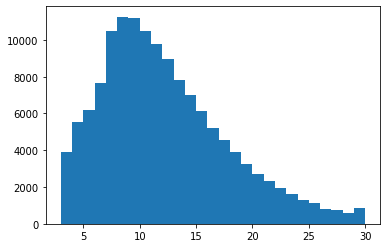

In [12]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [ ]:
from difflib import SequenceMatcher

def score_fun(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score_fun(original,generated))

The score must be computed as an average of at least 3K random examples taken form the test set.

## Daniele Simonazzi - 0001058929

## Transformer vs Seq2Seq

To solve this problem, I had to choose between a Seq2Seq model and a transformer model. The decision was actually pretty easy since I considered the limited amount of time available and the several following benefits of the transformer:
- Self-attention mechanism that allows it to focus on different parts of the input sequence during encoding and decoding phases
- Parallel processing that enables faster training and inference times
- Capability to capture long-range dependencies (due to attention and positional encoding), which eliminates the struggle of a Seq2Seq model when the distance between relevant words is significant

Here we can see the structure of the implemented transformer:

![Transformer structure](https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png)

## Batch generation

In [13]:
x_val = x_train[-1500:]
c_val = c_train[-1500:]
y_val = y_train[-1500:]

x_train = x_train[:-1500]
c_train = c_train[:-1500]
y_train = y_train[:-1500]

In [14]:
BATCH_SIZE = 64
BATCHES_PER_EPOCH = int(np.floor(x_train.shape[0]/BATCH_SIZE))
BATCHES_PER_EPOCH_VAL = int(np.floor(x_val.shape[0]/BATCH_SIZE))

class BatchIterator:
    def __init__(self, x_shuffled, x_original, y_shifted, batch_size, batches_per_epoch):
        self.x_shuffled = x_shuffled
        self.x_original = x_original
        self.y_shifted = y_shifted

        self.batch_size = batch_size
        self.batches_per_epoch = batches_per_epoch
        self.list_batches = []
         
        self._initialize_batches()
        
    def _initialize_batches(self):
        indices = [ii for ii in range(self.x_shuffled.shape[0])]
        random.shuffle(indices)
        for ii in range(self.batches_per_epoch):
            self.list_batches.append(indices[self.batch_size*ii : self.batch_size*(ii+1)])

    def __iter__(self):
        return self
    
    def __next__(self):
        if len(self.list_batches) == 0:
            self._initialize_batches()

        current_batch_indeces = self.list_batches.pop()

        batch_shuffled = self.x_shuffled[current_batch_indeces]
        batch_original = self.x_original[current_batch_indeces]
        batch_shifted = self.y_shifted[current_batch_indeces]

        return ([batch_shuffled,batch_original], batch_shifted)
    
MyBatchIterator_train = BatchIterator(x_train, c_train, y_train, BATCH_SIZE, BATCHES_PER_EPOCH)
MyBatchIterator_val = BatchIterator(x_val, c_val, y_val, BATCH_SIZE, BATCHES_PER_EPOCH_VAL)

## Positional encoding

Both the encoder and decoder use the same logic for embedding and positional encoding of inputs.   
To convert a sequence of tokens into vectors, both input and target tokens must pass through a tf.keras.layers.Embedding layer.
Since Transformers make no assumptions about the temporal/spatial relationships across the data we need to convey this information through "Positional Encoding".  
Hence, a word is represented by a vector which is the sum of a traditional encoding and a positional one. 
Throughout the model this mechanism allow attention layers to receive a set of vectors as input, with no specific order.  

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

Let’s use this to create a PositionalEmbedding layer that looks-up a token's embedding vector and adds the position vector:

In [15]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

## Add and Normalize

"Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a LayerNormalization layer. The residual "Add & Norm" blocks are included so that training is efficient

## Base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured.  
Each one contains a layers.MultiHeadAttention, a layers.LayerNormalization and a layers.Add.   
To implement these attention layers, let's start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass.

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

## The cross attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder.  
To implement this you pass the target sequence x (from the decoder) as the query and the context sequence (from the encoder) as the key/value when calling the multi-head-attention layer:

In [16]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x



## Global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length.  
To implement this layer you just need to pass the target sequence, x, as both the query, and value arguments to the multi-head-attention layer:

In [17]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## Causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence.  
Let's recall that Transformers are an "autoregressive" model: meaning that they generate the text one token at a time and feed that output back to the input.  
To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".  
To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention values.
This is taken care of automatically if you pass use_causal_mask = True to the MultiHeadAttention layer when you call it:

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## Feed forward network

The transformer also includes a point-wise feed-forward network in both the encoder and decoder.  
The network consists of two linear layers tf.keras.layers.Dense with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization.

In [18]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

## The encoder layer

The encoder contains a stack of N encoder layers. Where each EncoderLayer contains a GlobalSelfAttention and FeedForward layer.

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

## Encoder

Let’s now build the encoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

## The decoder layer

The decoder's stack is slightly more complex, with each DecoderLayer containing a CausalSelfAttention, a CrossAttention, and a FeedForward layer.

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

## Decoder

Let’s now build the decoder.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

## Transformer

In the end, in order to complete the Transformer model, the Encoder and the Decoder have to be put together and a final linear (Dense) layer which converts the resulting vector at each location into output token probabilities has to be added.  
The output of the decoder is the input to this final linear layer.  
Let's notice that actually the Transformer model output the logits and not the probabilities, however this will not create a problem since SparseCategoricalEntropyLoss provided by Keras can smoothly handle this.

In [21]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Hyperparameters 

Let's define the hyperparameters:

In [22]:
num_layers = 4 # the number of layers
d_model = 128 # the dimensionality of the embeddings
dff = 512 # internal dimensionality of the FeedForward layer
num_heads = 8 # self-attention heads
dropout_rate = 0.1

### Instantiate the Transformer model:

In [23]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=10000,
    target_vocab_size=10000,
    dropout_rate=dropout_rate)

### Set-up the optimizer

It s used an Adam optimizer where the learning rate varies over the course of training.  
It increases the learning rate linearly for the first warmup_steps training steps,
and decreases it thereafter proportionally to the inverse square root of the step number. 

In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.  
The cross-entropy loss function tf.keras.losses.SparseCategoricalCrossentropy is used.

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Training

Let's define a callback such that best weights and biases are dinamically stored

In [25]:
import os
import keras
import tensorflow as tf

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    os.path.join("transformer_weights_and_biases.h5"),    # Path to save the best weights
    monitor='val_loss',   # Metric to monitor for saving the best weights
    save_best_only=True,  # Save only the best weights
    save_weights_only=True  # Save only the weights, not the entire model
)

And let's plot the comparisons b/w training and validation loss and b/w  training and validation accuracy

In [26]:
def display_history(history):
    loss_training = history.history['loss']
    acc_training = history.history['masked_accuracy']

    loss_val = history.history['val_loss']
    acc_val = history.history['val_masked_accuracy']

    # Visualize the behavior of the loss
    plt.plot(loss_training)
    plt.plot(loss_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

Let’s first compile

In [27]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

And then let's train the model

Epoch 1/20
1478/1478 [==============================] - 1745s 1s/step - loss: 6.1835 - masked_accuracy: 0.2306 - val_loss: 4.3071 - val_masked_accuracy: 0.3919
Epoch 2/20
1478/1478 [==============================] - 1723s 1s/step - loss: 3.5831 - masked_accuracy: 0.4649 - val_loss: 2.7570 - val_masked_accuracy: 0.5612
Epoch 3/20
1478/1478 [==============================] - 1718s 1s/step - loss: 2.5303 - masked_accuracy: 0.5623 - val_loss: 2.1111 - val_masked_accuracy: 0.6154
Epoch 4/20
1478/1478 [==============================] - 1718s 1s/step - loss: 1.9184 - masked_accuracy: 0.6222 - val_loss: 1.6948 - val_masked_accuracy: 0.6608
Epoch 5/20
1478/1478 [==============================] - 1724s 1s/step - loss: 1.5524 - masked_accuracy: 0.6661 - val_loss: 1.5195 - val_masked_accuracy: 0.6858
Epoch 6/20
1478/1478 [==============================] - 1720s 1s/step - loss: 1.3368 - masked_accuracy: 0.6957 - val_loss: 1.4187 - val_masked_accuracy: 0.6998
Epoch 7/20
1478/1478 [==================

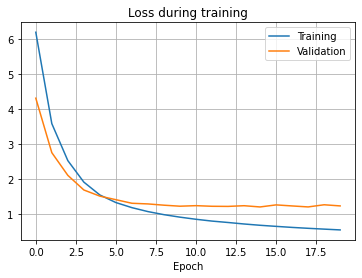

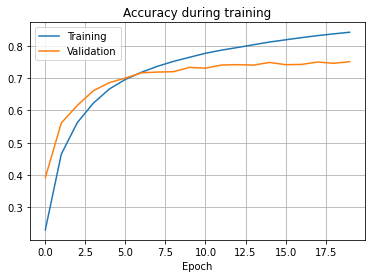

In [120]:
history = transformer.fit(MyBatchIterator_train,
                epochs=20,
                steps_per_epoch = BATCHES_PER_EPOCH,
                validation_steps = BATCHES_PER_EPOCH_VAL,
                validation_data=MyBatchIterator_val,
                callbacks = [checkpoint_callback])

display_history(history)

It can be easily noticed an overfit.  
I tried to tackle this problem by trying several different hyperparameters set-ups and by augmenting datas without any improvements. 

## Inference

Let’s now run the inference dynamic one token at a time

In [28]:
MAX_TOKENS = 32

class shuffle_inverter_class(tf.Module):
  def __init__(self, transformer):
    self.transformer = transformer

  def __call__(self, shuffled_sentence, max_length=MAX_TOKENS):

    encoder_input = shuffled_sentence 

    output = np.ones(shape = (1,1))*2 # adding <start>

    for i in tf.range(max_length):
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predicted = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = np.argmax(predicted, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output = np.concatenate((output, predicted_id), axis=1)

      if predicted_id == 3:
        break

    reordered_sentence = output

    return reordered_sentence

In [29]:
shuffled_sen = np.expand_dims(x_test[0], axis=0)
results = np.ones(shape=(1,32))*2

shuffle_inverter = shuffle_inverter_class(transformer)
shuffle_inverter(shuffled_sen)

transformer.load_weights('transformer_weights_and_biases.h5')

In [30]:
from difflib import SequenceMatcher

def score_fun(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(s),len(p)))

In [31]:
import sys

avg_score = 0
nn = 3000

def score_generator():
    while True:
        sen_indices = [ii for ii in range(x_test.shape[0])]
        random.shuffle(sen_indices) 
        sen_indices = sen_indices[:nn]

        for index in sen_indices:
            original_sentence = c_test[index]
            shuffled_sentence = np.expand_dims(x_test[index], axis = 0)
            ordered_sentence = shuffle_inverter(shuffled_sentence)[0]

            original = tokenizer.sequences_to_texts([original_sentence[original_sentence > 3]])[0]
            ordered = tokenizer.sequences_to_texts([ordered_sentence[ordered_sentence > 3]])[0]

            score = score_fun(original, ordered)
            yield score

score_gen = iter(score_generator())
for ii in range(nn):
    sys.stdout.write(f"\rProcessing sentence n°{ii}")
    sys.stdout.flush()
    avg_score += next(score_gen)/nn

print(f"\nThe average score computed over 3000 sentences is: {avg_score}")

Processing sentence n°0

Processing sentence n°2999
The average score computed over 3000 sentences is: 0.4857659387443567


# What to deliver

You are supposed to deliver a single notebook, suitably commented. 
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training. 
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!